In [1]:
%matplotlib notebook

import logging
import time

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes
from qcodes import new_experiment, initialise_or_create_database_at, \
    Station, find_or_create_instrument

# Imports

In [2]:
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208

In [3]:
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360

In [4]:
from pytopo.awg_sequencing import broadbean as bbtools
from pytopo.rf.alazar import acquisition_tools
from pytopo.rf.alazar import awg_sequences
from pytopo.rf.alazar import acquisition_controllers

In [5]:
from pytopo.rf.alazar.awg_sequences import AlazarTestSequence
from pytopo.rf.alazar.awg_sequences import TriggerSequence

# Init

## initialize station, create instruments

In [6]:
station = Station()

alazar = AlazarTech_ATS9360('alazar')
station.add_component(alazar)

awg = AWG5208('awg', 'TCPIP0::169.254.200.177::inst0::INSTR')
station.add_component(awg)

Connected to: TEKTRONIX AWG5208 (serial:B020202, firmware:FV:6.1.0054.0) in 0.13s


'awg'

In [7]:
initialise_or_create_database_at(r".\experiments.db")

In [8]:
raw_acq = find_or_create_instrument(acquisition_controllers.RawAcqCtl, 
                               'raw_acq', 'alazar',
                               allocate_samples=1e9, 
                               recreate=True)
station.add_component(raw_acq)

acquisition_controllers.PostDemodCtl._datadtype = np.int32
post_demod_acq = find_or_create_instrument(
    acquisition_controllers.PostDemodCtl, 'post_demod_acq', 'alazar',
    allocate_samples=1e9, 
    recreate=True)
station.add_component(post_demod_acq)

post_iq_acq = find_or_create_instrument(
    acquisition_controllers.PostIQCtl, 'post_iq_acq', 'alazar', 
    allocate_samples=1e9,
    recreate=True)
station.add_component(post_iq_acq)

Allocating 1000000000 elements (2000.0 MB, dtype: <class 'numpy.uint16'>)
Allocating 1000000000 elements (4000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 1000000000 elements (4000.0 MB, dtype: <class 'numpy.int32'>)


'post_iq_acq'

In [9]:
if isinstance(station.awg, Tektronix_AWG5014):
    AWGTYPE = '5014'
elif isinstance(station.awg, AWG5208):
    AWGTYPE = '5208'
else:
    raise Exception('No usable AWG.')
    
print(AWGTYPE)

5208


## Basic instrument config

In [10]:
# adopt this for your case. different cards have different allowed ranges.
with station.alazar.syncing():
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)
    
    station.alazar.sample_rate(0.5e9)

## Test sequence

In [11]:
AlazarTestSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None]
}
AlazarTestSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

<IPython.core.display.Javascript object>


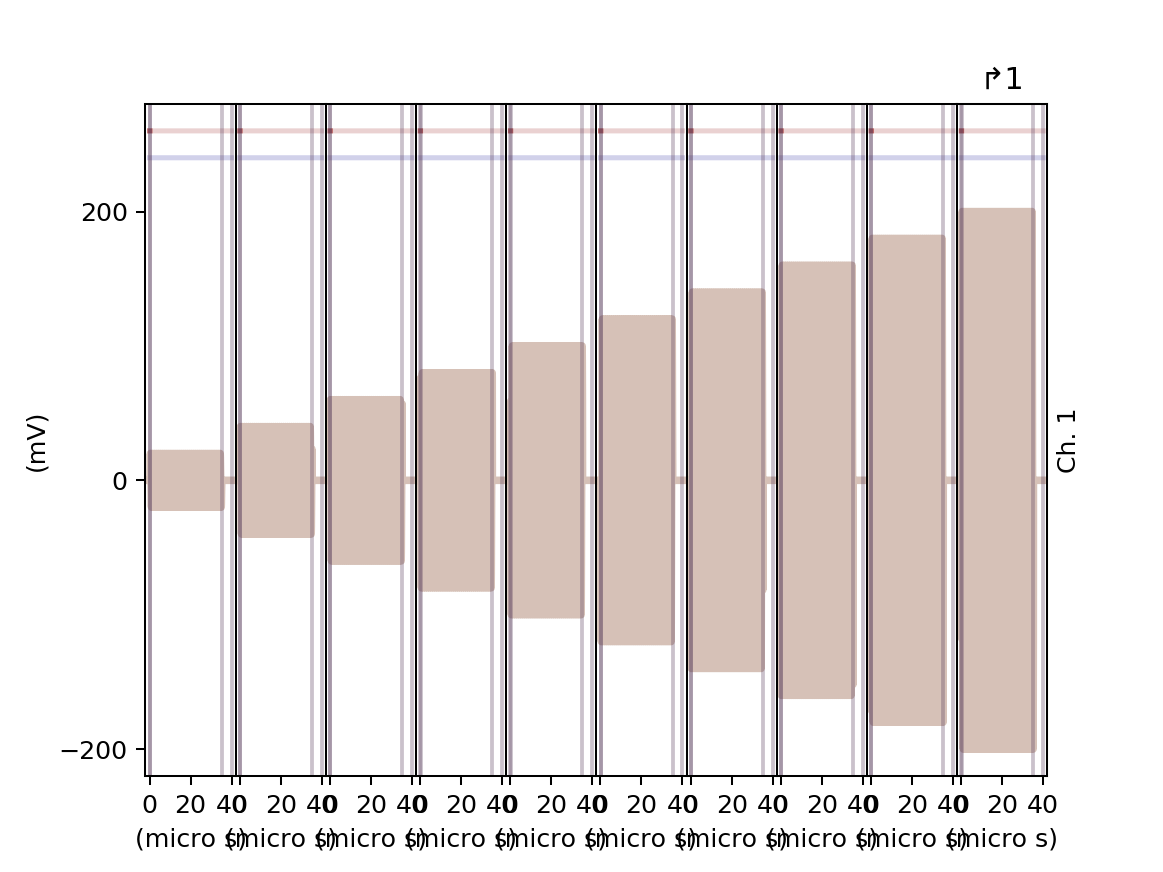

In [13]:
N = 10
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

test_seq = AlazarTestSequence(station.awg)
test_seq.wait = 'off'
test_seq.setup_awg(pulse_times=pulse_times, frequencies=frequencies, 
                   phases=phases, amplitudes=amplitudes, 
                   cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6,
                   plot=True)

# Test basic controllers

## Raw data

In [14]:
t_rep = 40e-6
nsamples = 384 * 1
npts = int(1e5)
nrecords = 100
alloc_buffers = 5
SR = 1e7 * 1

t_total = npts * t_rep
nbuffers = npts // nrecords

In [15]:
t, data = acquisition_tools.time_acquisition(
    raw_acq,
    nsamples, nrecords, nbuffers,
    alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 153.60000000000002 MB total
 * Buffers: 1000 (0.15360000000000001 MB/buffer) | (Allocated buffers: 5 = 0.768 MB)
 * Records: 100 (0.001536 MB/record)
 * Samples: 384 (= 38.4 us)
 * Channels: 2
done: 0.4459824249880171 s
Acquistion: 4.472870 sec.
Net time: 4.000000 sec.
Overhead: 1.12 X
Mean buffer handling time: 0.2 ms
post_acquire time: 0.32 s
Data shape: (1, 1000, 100, 384, 2)

 


<IPython.core.display.Javascript object>


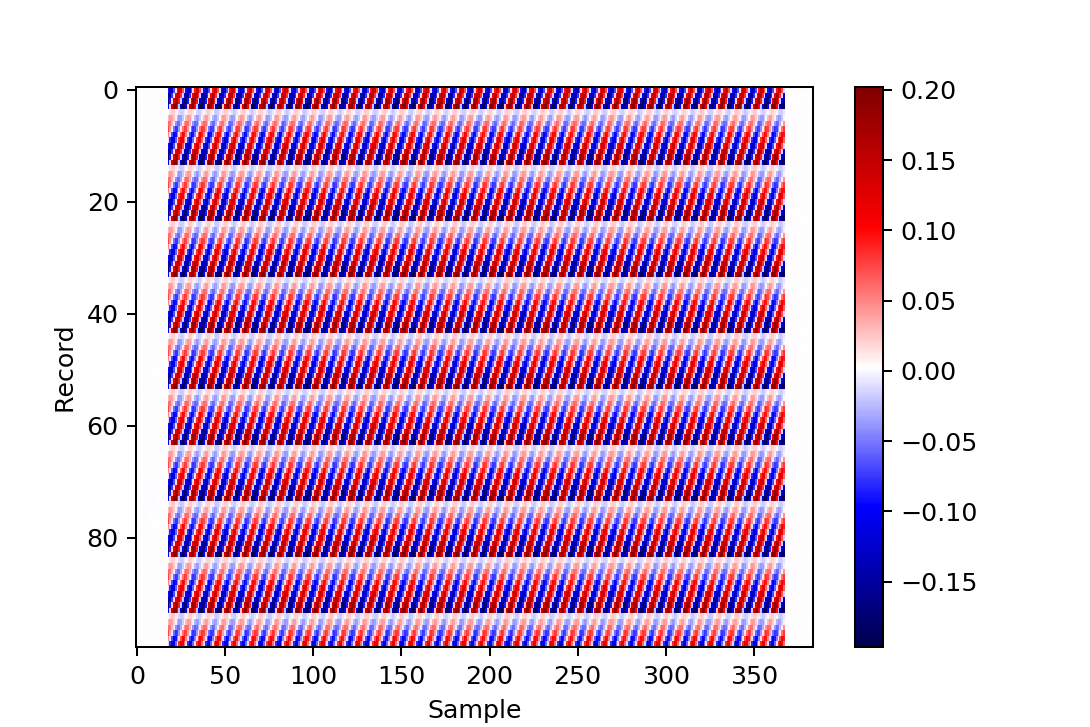

<IPython.core.display.Javascript object>


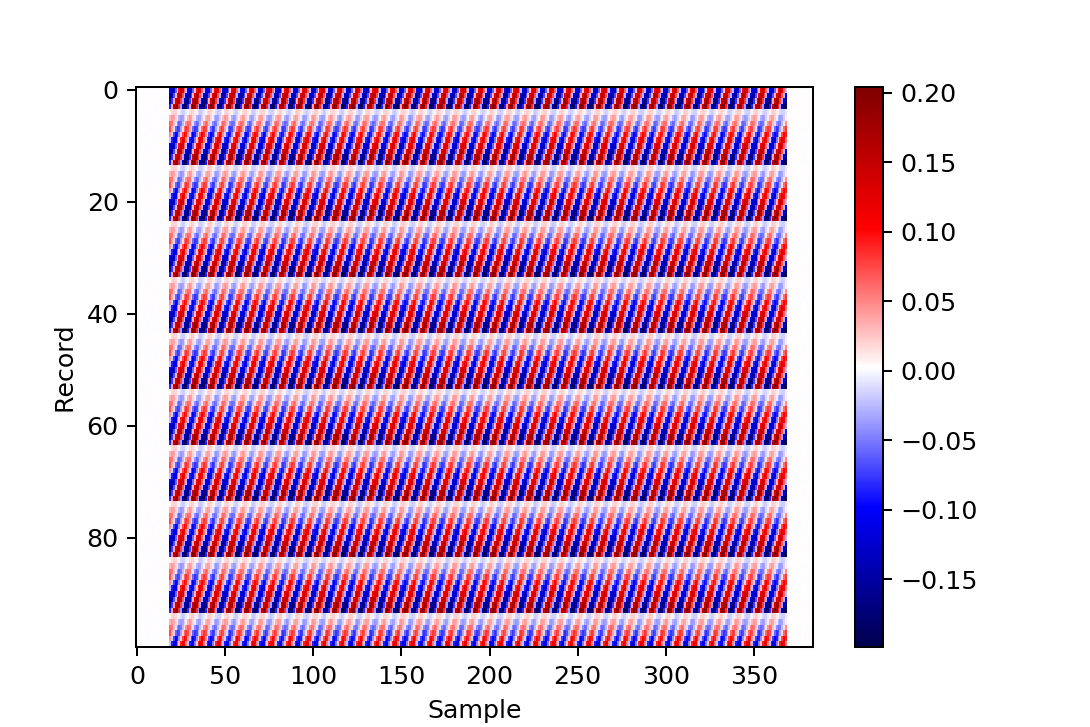

Text(0, 0.5, 'Record')

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, 0, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, -10, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

## Post-acq. demodulation

### Only demodulation

In [17]:
post_demod_acq.average_buffers(True)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 3840 - 128
npts = int(1e4)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

In [18]:
t, data = acquisition_tools.time_acquisition(
    post_demod_acq,
    nsamples, nrecords, nbuffers,
    alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 296.96 MB total
 * Buffers: 100 (2.9696 MB/buffer) | (Allocated buffers: 10 = 29.695999999999998 MB)
 * Records: 100 (0.029696 MB/record)
 * Samples: 3712 (= 37.12 us)
 * Channels: 2
done: 0.3520241958227359 s
Acquistion: 0.574252 sec.
Net time: 0.400000 sec.
Overhead: 1.44 X
Mean buffer handling time: 2.0 ms
post_acquire time: 0.07 s
Data shape: (1, 1, 100, 37, 2)

 


In [19]:
iqdata = data.mean(axis=-2)
mag = np.abs(iqdata)
phase = np.angle(iqdata, deg=True)
phase[phase < -180] += 360

<IPython.core.display.Javascript object>


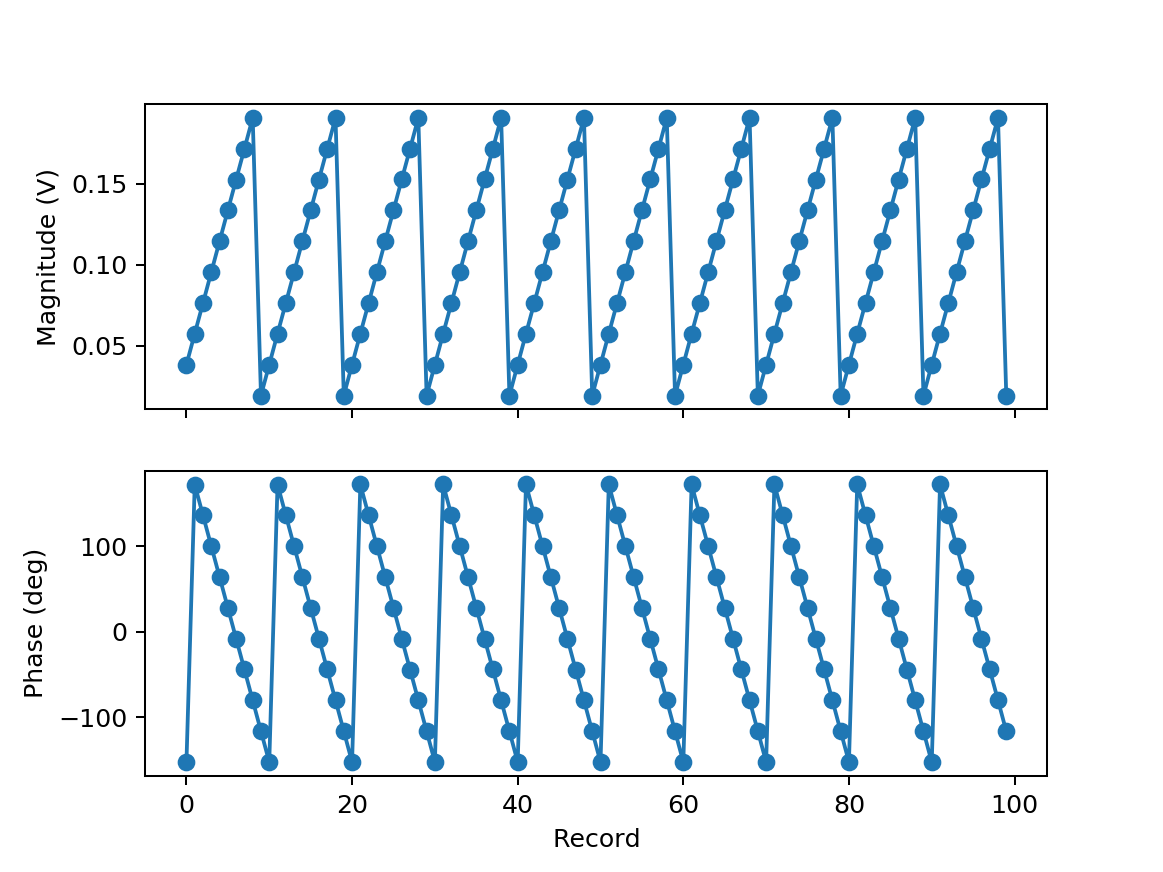

Text(0, 0.5, 'Phase (deg)')

In [20]:
fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting I/Q

In [21]:
post_iq_acq.average_buffers(True)
post_iq_acq.buffers_per_block(None)
post_iq_acq.integration_start(1.25e-6)
post_iq_acq.integration_stop(11.25e-6)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 3840 - 128
npts = int(1e4)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

In [22]:
t, data = acquisition_tools.time_acquisition(
    post_iq_acq,
    nsamples, nrecords, nbuffers,
    alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 296.96 MB total
 * Buffers: 100 (2.9696 MB/buffer) | (Allocated buffers: 10 = 29.695999999999998 MB)
 * Records: 100 (0.029696 MB/record)
 * Samples: 3712 (= 37.12 us)
 * Channels: 2
done: 0.3469151352437052 s
Acquistion: 0.573029 sec.
Net time: 0.400000 sec.
Overhead: 1.43 X
Mean buffer handling time: 1.9 ms
post_acquire time: 0.07 s
Data shape: (1, 1, 100, 2)

 


In [23]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

<IPython.core.display.Javascript object>


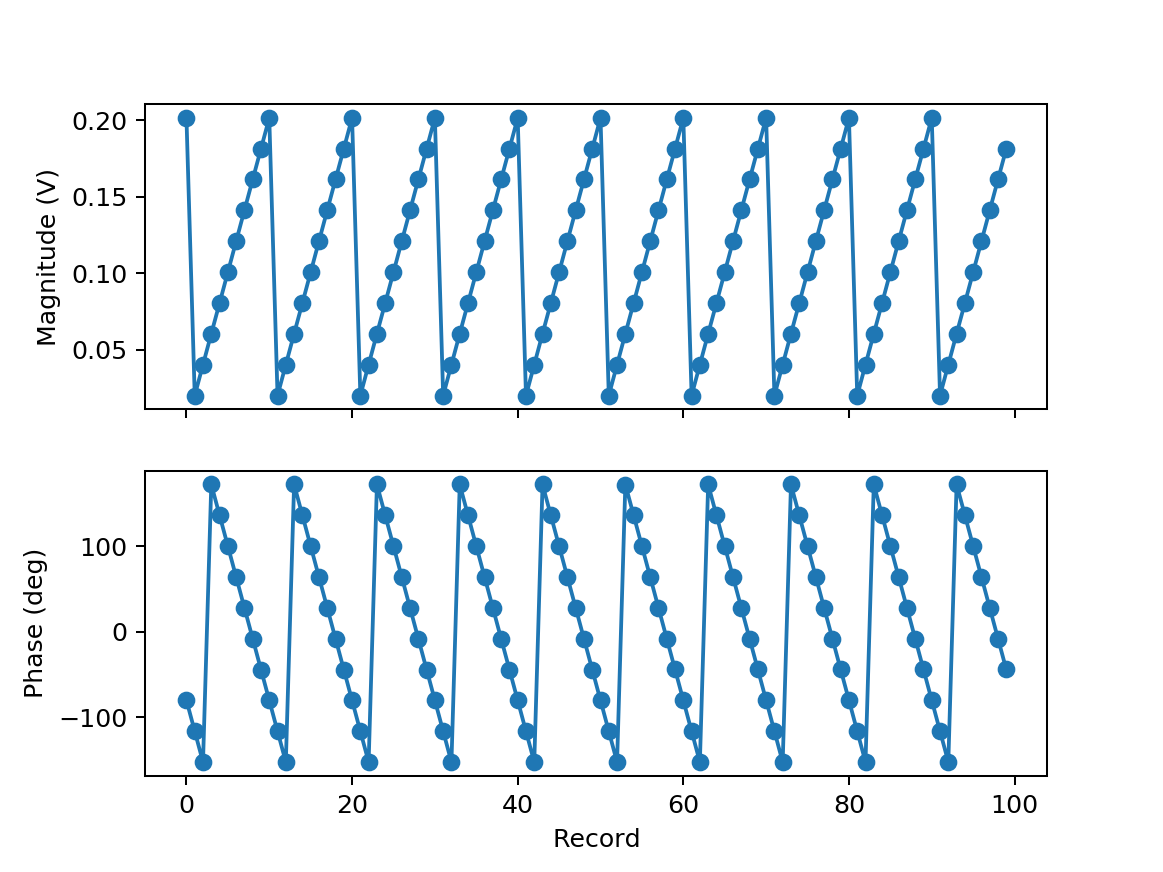

Text(0, 0.5, 'Phase (deg)')

In [24]:
fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting IQ and usage of buffer blocks

ro_trigger not defined. omitting.
ro_trigger not defined. omitting.
ro_trigger not defined. omitting.
ro_trigger not defined. omitting.
ro_trigger not defined. omitting.
ro_trigger not defined. omitting.


<IPython.core.display.Javascript object>


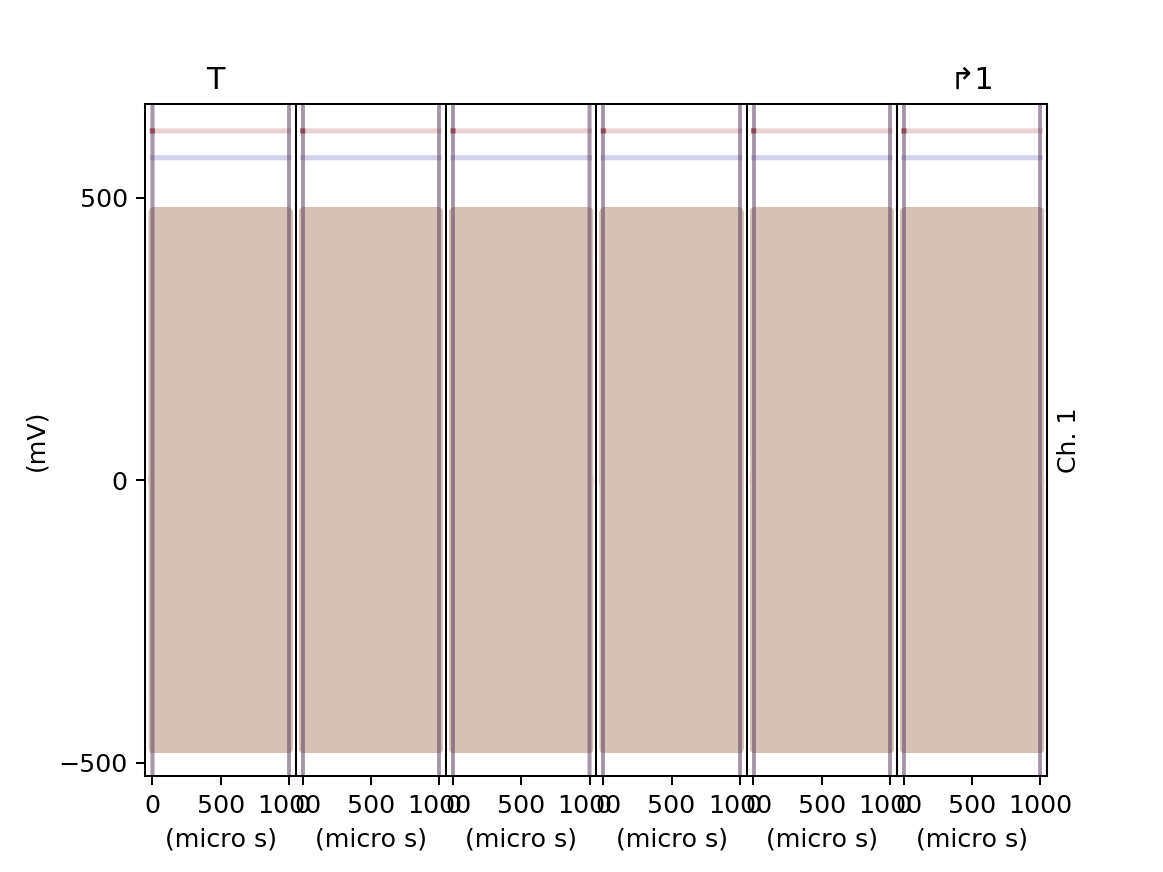

In [26]:
TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None]
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

trig_seq = TriggerSequence(station.awg, SR=1e7)
trig_seq.wait = 'first'
trig_seq.setup_awg(cycle_time=1e-3, debug_signal=True, ncycles=6, plot=True)

In [27]:
class MyPostIQCtl(acquisition_controllers.PostIQCtl):
    
    def _perform_step(self, num):        
        awg = station.awg
        if AWGTYPE == '5208':
            while awg.run_state() != 'Waiting for trigger':
                time.sleep(0.01)
        else:
            while awg.get_state() != 'Waiting for trigger':
                time.sleep(0.01)
                   
        time.sleep(0.1)
        if not (num+1) % self.buffers_per_block():
            inc = (num+1) // self.buffers_per_block()
            if AWGTYPE == '5208':
                awg.ch1.awg_amplitude(0.25 + inc * 0.05)
            else:
                station.awg.ch1_amp(0.25 + inc * 0.05)
            time.sleep(0.01)     
            
        if AWGTYPE == '5208':
            awg.force_triggerA()
        else:
            awg.force_trigger()
        
    def pre_acquire(self):
        super().pre_acquire()
        self._perform_step(0)
        self._perform_step(1)
    
    def buffer_done_callback(self, buffernum):
        nextstep = buffernum + 2
        self._perform_step(nextstep)

my_iq_acq = find_or_create_instrument(
    MyPostIQCtl, 'my_iq_acq', 'alazar',
    allocate_samples=1e7,
    recreate=True)

Allocating 10000000 elements (40.0 MB, dtype: <class 'numpy.int32'>)


In [28]:
if AWGTYPE == '5208':
    station.awg.ch1.awg_amplitude(0.25)
else:
    station.awg.ch1_amp(0.25)

In [29]:
my_iq_acq.average_buffers(True)
my_iq_acq.buffers_per_block(10)

demod_frq = 1e6
t_rep = 1e-3
nsamples = 100e-6 * 1e8 // 128 * 128
nbuffers = 100
nrecords = 6
alloc_buffers = 10
SR = 1e8

t_total = nbuffers * t_rep

In [30]:
t, data = acquisition_tools.time_acquisition(
    my_iq_acq,
    nsamples, nrecords, nbuffers, 
    alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 47.9232 MB total
 * Buffers: 100 (0.479232 MB/buffer) | (Allocated buffers: 10 = 4.79232 MB)
 * Records: 6 (0.079872 MB/record)
 * Samples: 9984 (= 99.84 us)
 * Channels: 2
done: 0.3465060389360133 s
Acquistion: 13.369035 sec.
Net time: 0.100000 sec.
Overhead: 133.69 X
Mean buffer handling time: 0.7 ms
post_acquire time: 0.11 s
Data shape: (10, 1, 6, 2)

 


<IPython.core.display.Javascript object>


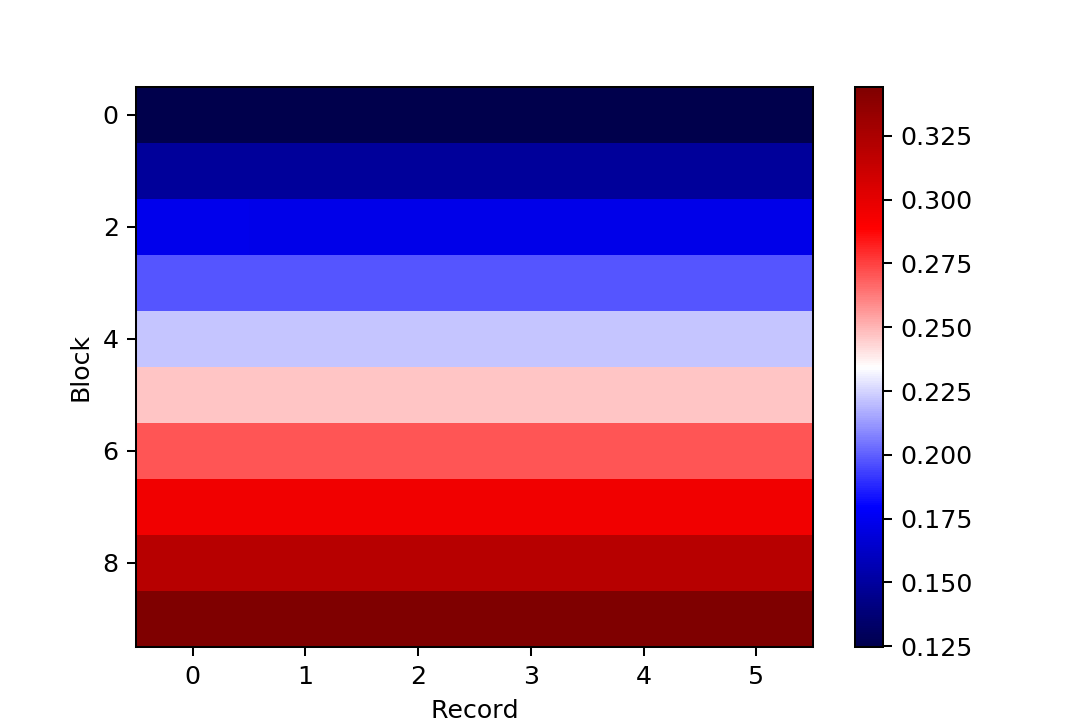

Text(0, 0.5, 'Block')

In [31]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(mag[:, 0, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Record')
ax.set_ylabel('Block')

# Using pytopo.sweep

## Test sequence

<IPython.core.display.Javascript object>


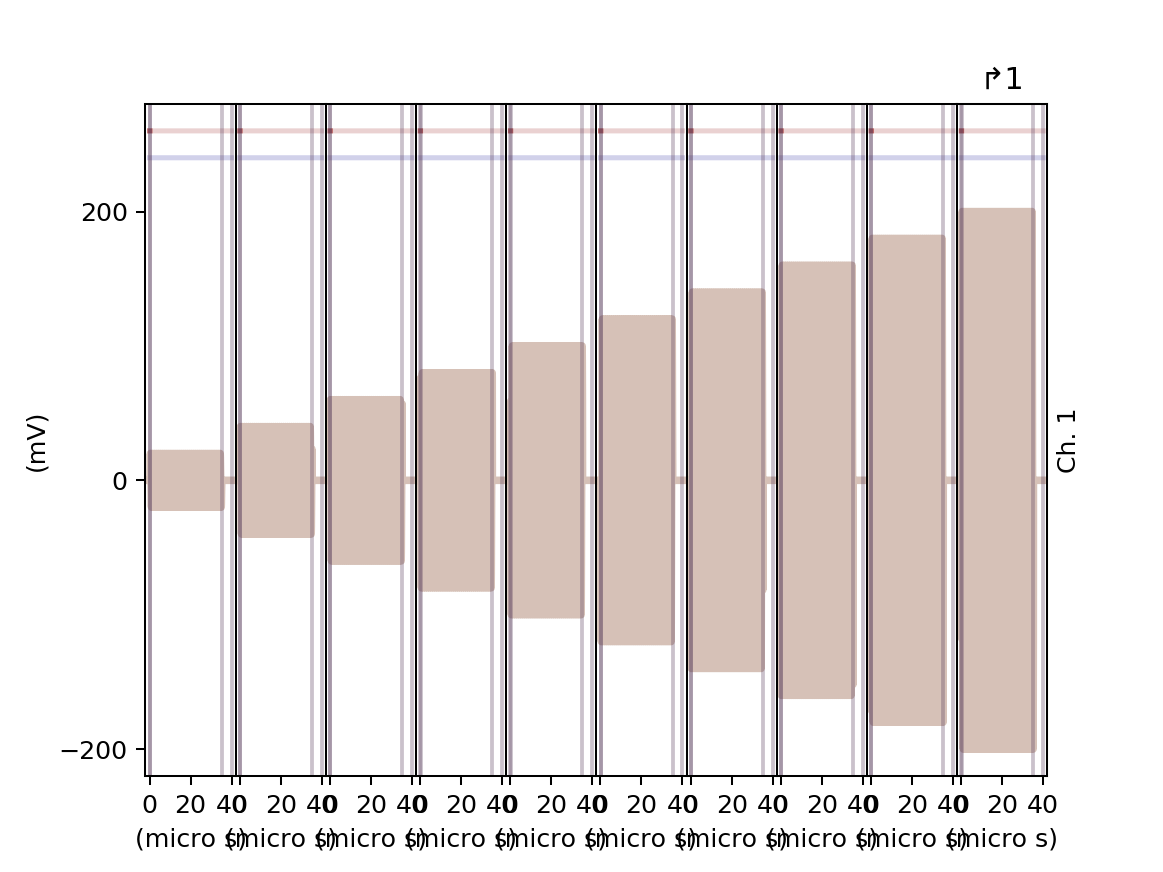

In [33]:
N = 10
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

test_seq = AlazarTestSequence(station.awg)
test_seq.wait = 'off'
test_seq.setup_awg(pulse_times=pulse_times, frequencies=frequencies, 
                   phases=phases, amplitudes=amplitudes, 
                   cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6,
                   plot=True)

## Intro: remind ourselves what sweep does

In [34]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id
from qcodes.dataset import measurements

from pytopo.sweep import sweep, do_experiment, measure, hardsweep, getter, setter

In [35]:
@setter(('a', 'M'), ('b', 'N'))
def set_stuff(a, b):
    print(f'Setting a = {a} and b = {b}')
    return a, b

@getter(('x', 'A'), ('y', 'B'))
def measure_stuff():
    print(f'Found x = 1, y = 10')
    return 1, 10

In [36]:
sweep_object = sweep(set_stuff, [(1, 2), (3, 4)])(
    measure(measure_stuff)
)

In [37]:
for s in sweep_object:
    print(s)

Setting a = 1 and b = 2
Found x = 1, y = 10
{'x': 1, 'y': 10, 'a': 1, 'b': 2}
Setting a = 3 and b = 4
Found x = 1, y = 10
{'x': 1, 'y': 10, 'a': 3, 'b': 4}


## Simple Example: repeated time traces

In [38]:
@hardsweep(ind=[('tvals', 'us', 'array')], dep=[('signal', 'V', 'array')])
def alazar_timetrace(setup_controller=True):
    time.sleep(0.5)
    print(f'Iteration: {it()+1}', end='\r')
    
    t_acq = 5e-6
    SR = 1e8
    
    station = qcodes.Station.default
    ctl = station.raw_acq
    ctl.buffers_per_block(None)
    
    with station.alazar.syncing():
        station.alazar.sample_rate(SR)
        
    if setup_controller:
        ctl.setup_acquisition(samples=int(t_acq * SR // 128 * 128), records=1,
                              buffers=2, verbose=False)
        
    data = np.squeeze(ctl.acquisition())[0,...,0]    
    return ctl.tvals.reshape(-1) * 1e6, data.reshape(-1)

In [39]:
it = Parameter('iteration', set_cmd=None, initial_value=1)

In [40]:
so = sweep(it, range(20))(
    alazar_timetrace(),
)

In [41]:
result = do_experiment("test_hardsweep/None", so, live_plot=True)

c:\users\administrator\code\pytopo\pytopo\sweep\do_experiment.py:77: UserWarning: Cannot perform live plots, plottr not installed
  warn("Cannot perform live plots, plottr not installed")


Starting experimental run with id: 3


<IPython.core.display.Javascript object>


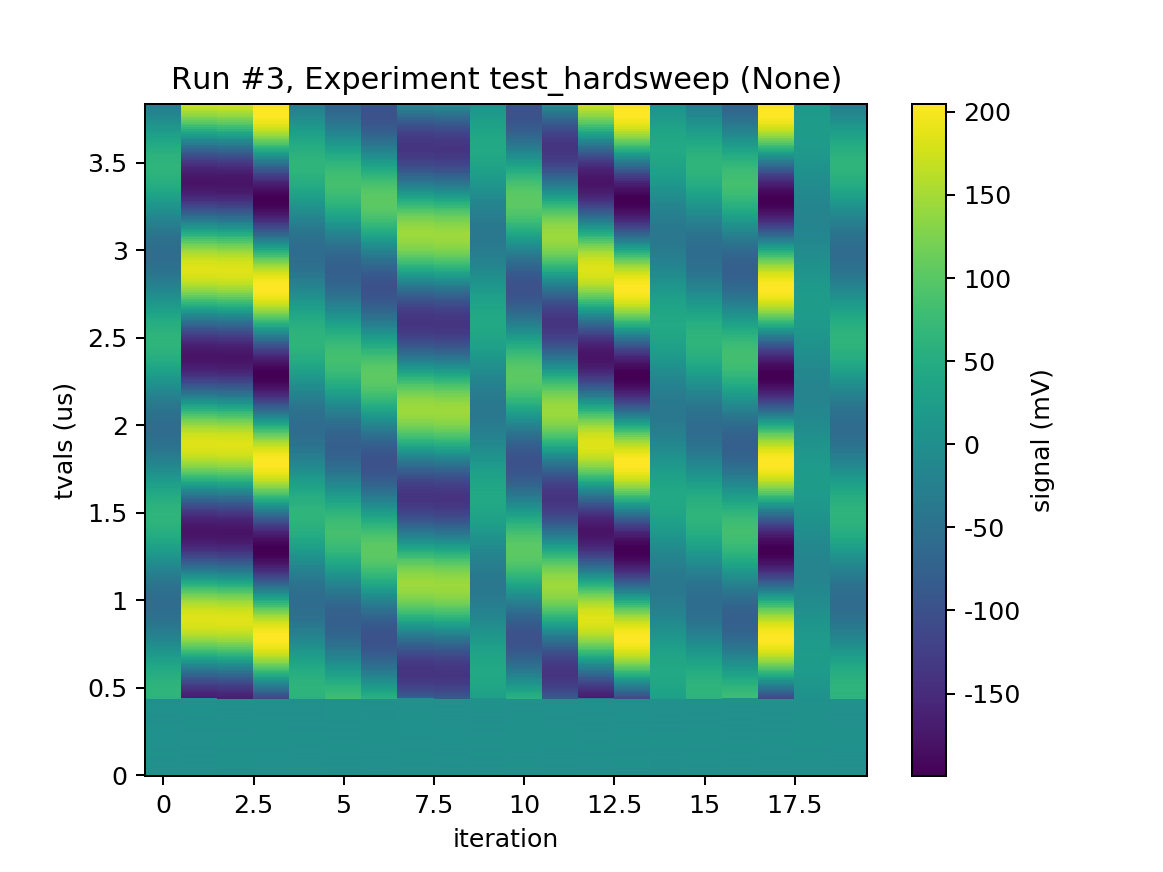

([<matplotlib.axes._subplots.AxesSubplot at 0x22019ba0518>],
 [<matplotlib.colorbar.Colorbar at 0x22024b9c400>])

In [42]:
plot_by_id(result.run_id)

## Repeated IQ maps

In [43]:
@hardsweep(
    ind=[('column', '', 'array'), ('row', '', 'array')], 
    dep=[('magnitude', 'V', 'array'), ('phase', 'deg', 'array')]
)
def alazar_iq_test(nrows=10, ncols=10, navgs=1, setup_controller=True):
    time.sleep(0.5)
    print(f'Iteration: {it()+1}', end='\r')
    
    t_acq = 15e-6
    SR = 1e8
    
    station = qcodes.Station.default
    ctl = station.post_iq_acq
    ctl.buffers_per_block(None)
    ctl.average_buffers(True)
    ctl.integration_start(1.25e-6)
    ctl.integration_stop(11.25e-6)
    
    with station.alazar.syncing():
        station.alazar.sample_rate(SR)
        
    if setup_controller:
        ctl.setup_acquisition(samples=int(t_acq * SR // 128 * 128), 
                              records=nrows*ncols,
                              buffers=navgs, verbose=False)
        
    data = ctl.acquisition()
    data = np.squeeze(data)[...,0].reshape(ncols, nrows)
    mag, phase = np.abs(data), np.angle(data, deg=True)
    cc, rr = np.meshgrid(np.arange(ncols), np.arange(nrows), indexing='ij')
    
    return ( np.vstack((cc.reshape(-1), rr.reshape(-1))), 
             np.vstack((mag.reshape(-1), phase.reshape(-1))) )

In [44]:
so = sweep(it, range(3))(
    alazar_iq_test(20, 20, 1),
)

In [45]:
result = do_experiment("test_hardsweep/None", so, live_plot=True)

c:\users\administrator\code\pytopo\pytopo\sweep\do_experiment.py:77: UserWarning: Cannot perform live plots, plottr not installed
  warn("Cannot perform live plots, plottr not installed")


Starting experimental run with id: 4


<IPython.core.display.Javascript object>


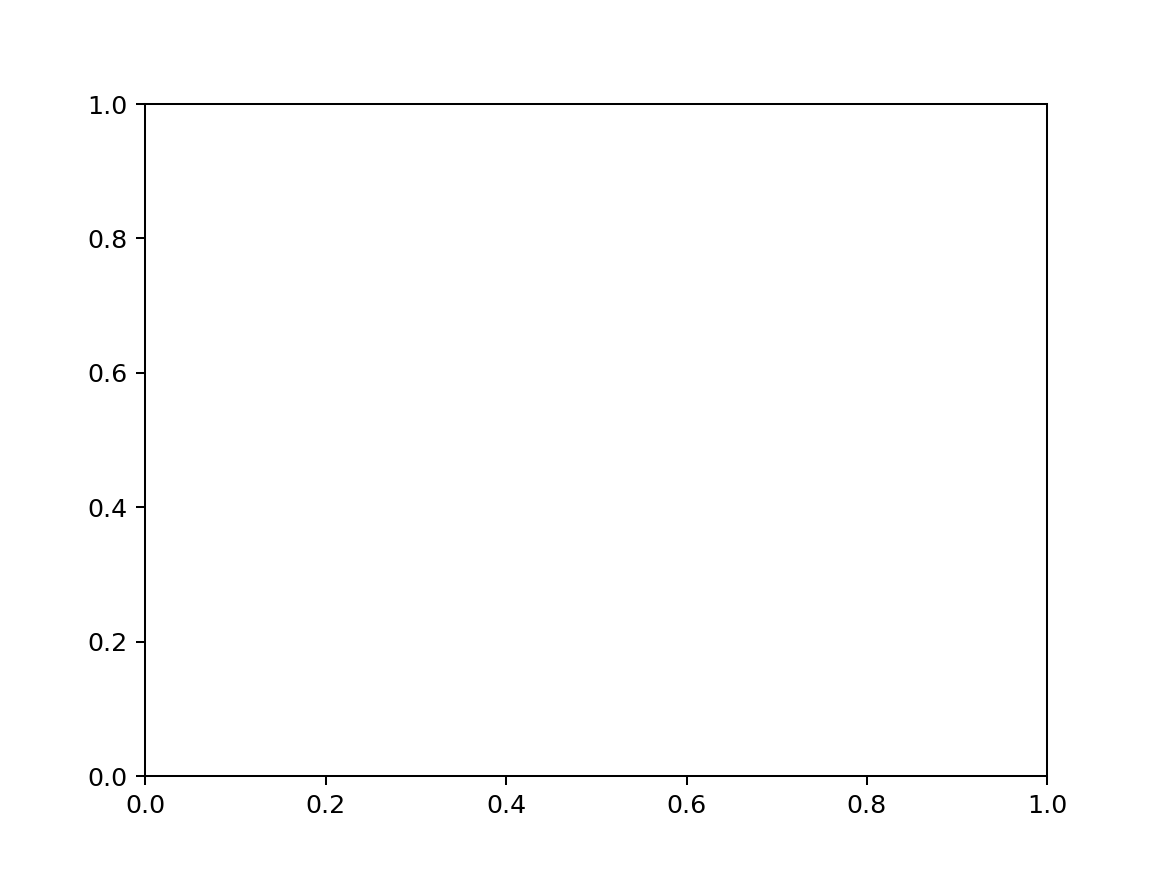

<IPython.core.display.Javascript object>


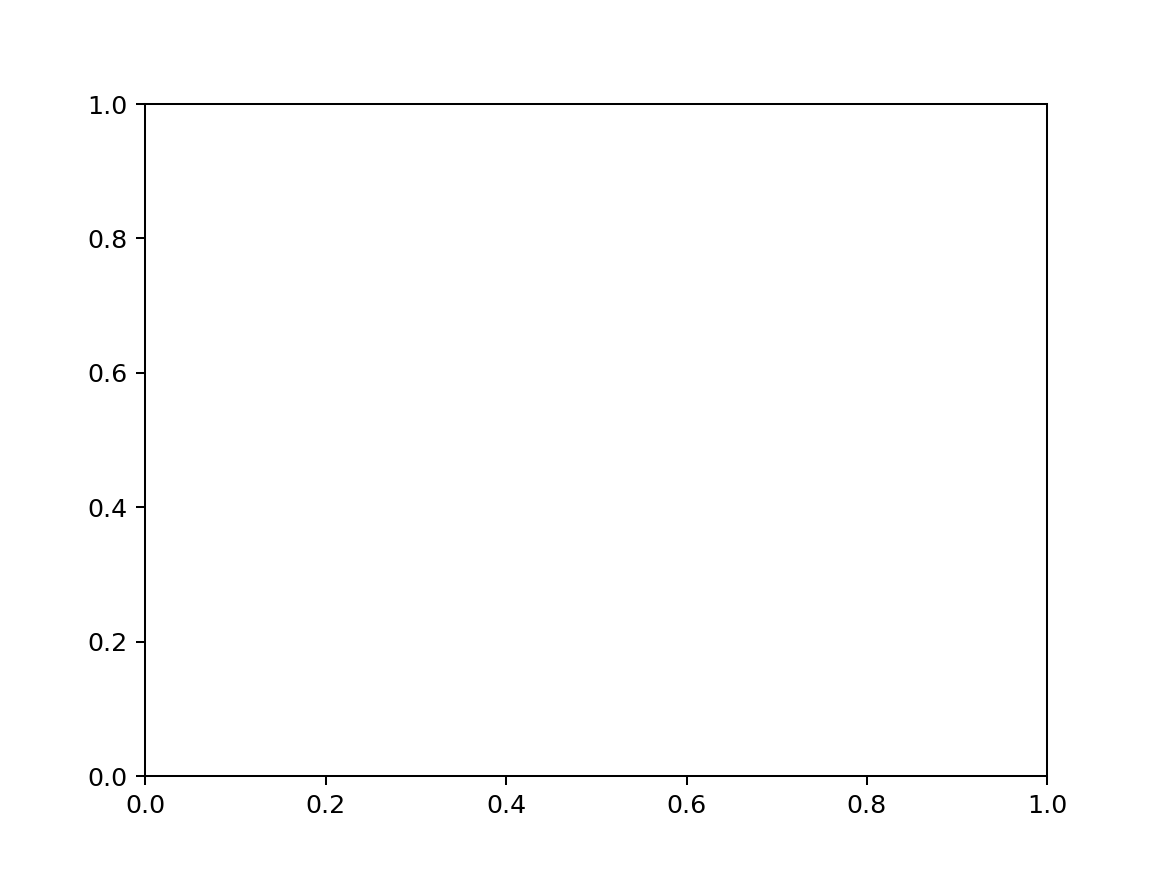

Multi-dimensional data encountered. parameter magnitude depends on 3 parameters, cannot plot that.
Multi-dimensional data encountered. parameter phase depends on 3 parameters, cannot plot that.


([<matplotlib.axes._subplots.AxesSubplot at 0x22020b19320>,
 [None, None])

In [46]:
plot_by_id(result.run_id)